##Image Segmentation


In this notebook we move all the images and masks in each crop/sensor folder to a single folder in order to make the image training more easier.

Then we carry out the necessary data augumentations steps and other preprocessing steps for image segmentation.

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
import os

# os.environ["CUDA_VISIBLE_DEVICES"]="-1" 
import tensorflow as tf
import numpy as np

# Set the seed for random operations. 
# This let our experiments to be reproducible. 
SEED = 1234
tf.random.set_seed(SEED) 

In [4]:
cwd = os.getcwd()

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!unzip '/content/drive/MyDrive/Kaggle/Development_Dataset.zip'

Archive:  /content/drive/MyDrive/Kaggle/Development_Dataset.zip
  inflating: Development_Dataset/LICENSE.txt  
   creating: Development_Dataset/Test_Dev/
   creating: Development_Dataset/Test_Dev/Bipbip/
   creating: Development_Dataset/Test_Dev/Bipbip/Haricot/
   creating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_00211.jpg  
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_00581.jpg  
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_00721.jpg  
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_00951.jpg  
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_01341.jpg  
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_02421.jpg  
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_02781.jpg  
  inflating: De

#DataSet

In [7]:
# ImageDataGenerator
# ------------------

from tensorflow.keras.preprocessing.image import ImageDataGenerator

input_dir = True

# Create training ImageDataGenerator object
# We need two different generators for images and corresponding masks
if input_dir:
  inp_img_data_gen = ImageDataGenerator(validation_split =0.2)
  inp_mask_data_gen = ImageDataGenerator(validation_split =0.2,)

test_img_data_gen = ImageDataGenerator(rescale=1./255)
test_mask_data_gen = ImageDataGenerator()

In [8]:
apply_data_augmentation = True
if apply_data_augmentation:
    img_data_gen = ImageDataGenerator(rotation_range=10,
                                      width_shift_range=10,
                                      height_shift_range=10,
                                      zoom_range=0.3,
                                      horizontal_flip=True,
                                      vertical_flip=True,
                                      fill_mode='reflect')
    mask_data_gen = ImageDataGenerator(rotation_range=10,
                                       width_shift_range=10,
                                       height_shift_range=10,
                                       zoom_range=0.3,
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       fill_mode='reflect')

In [9]:
#This function will move the images from their respective folders to a single folder so that we get more images for training
def folderImages(path, training_dir):               
    targetImage_dir = path+'trainingData/trainingImages'
    targetMask_dir = path+'trainingData/trainingMasks'

    file_namesImage = os.listdir(training_dir+'Images/')

    for file_name in file_namesImage:
        shutil.move(os.path.join(training_dir+'Images/', file_name), targetImage_dir)

    file_namesMask = os.listdir(training_dir+'Masks/')                                                # move all the images and masks to one folder

    for file_name in file_namesMask:
        shutil.move(os.path.join(training_dir+'Masks/', file_name), targetMask_dir)

In [10]:
import shutil, random, json

RESET_VALIDATION = True                    # if True the split of train and validation is run again randomly, if False the split remain the same

DATASET_SPLIT = 0.8

path = '/content/Development_Dataset/'

if not os.path.exists(path) or RESET_VALIDATION:                # if the split doesn't exists OR if we want to create a new split, the new split is generated, otherwise not
    if not os.path.exists(path+'/trainingData'):
      os.mkdir(path+'/trainingData')
      if not os.path.exists(path+'/trainingData/trainingImages'):
        os.mkdir(path+'/trainingData/trainingImages')
      if not os.path.exists(path+'/trainingData/trainingMasks'):
        os.mkdir(path+'/trainingData/trainingMasks')

    dataset_dir = os.path.join(cwd, 'Development_Dataset')
    
    #Here we call the function to move all the images and their respective masks to a single folder
    bipHaricot_training_dir = os.path.join(dataset_dir, 'Training/Bipbip/Haricot/')
    bipMais_training_dir = os.path.join(dataset_dir, 'Training/Bipbip/Mais/')                                  

    peHaricot_training_dir = os.path.join(dataset_dir, 'Training/Pead/Haricot/')
    peMais_training_dir = os.path.join(dataset_dir, 'Training/Pead/Mais/')

    # rosHaricot_training_dir = os.path.join(dataset_dir, 'Training/Roseau/Haricot/')
    # rosMais_training_dir = os.path.join(dataset_dir, 'Training/Roseau/Mais/')

    # weedHaricot_training_dir = os.path.join(dataset_dir, 'Training/Weedelec/Haricot/')
    # weedMais_training_dir = os.path.join(dataset_dir, 'Training/Weedelec/Mais/')

    folderImages(path, bipHaricot_training_dir)
    folderImages(path, bipMais_training_dir)

    # folderImages(path, peHaricot_training_dir)
    # folderImages(path, peMais_training_dir)

    # folderImages(path, rosHaricot_training_dir)
    # folderImages(path, rosMais_training_dir)

    # folderImages(path, weedHaricot_training_dir)
    # folderImages(path, weedMais_training_dir)

print(len(os.listdir(path+'trainingData/trainingImages')))
print(len(os.listdir(path+'trainingData/trainingMasks')))

180
180


In [11]:
# Create generators to read images from dataset directory
# -------------------------------------------------------
dataset_dir = os.path.join(cwd, 'Development_Dataset')

# img

# Batch size
bs = 16

# img shape
img_h = 256
img_w = 256

# Training
img_training_dir = os.path.join(dataset_dir, 'trainingData/')
print(len(os.listdir(img_training_dir)))

# Training
#img_training_dir = os.path.join(dataset_dir, 'Training/Bipbip/Haricot/')
train_img_gen = inp_img_data_gen.flow_from_directory(img_training_dir,
                                                       classes = ['trainingImages'],
                                               target_size=(img_h, img_w),
                                                       batch_size=bs,
                                                       class_mode=None, 
                                                     interpolation='bilinear',
                                                       shuffle=True,
                                                       
                                                       seed=SEED,
                                                       subset='training')  # targets are directly converted into one-hot vectors

train_mask_gen = inp_mask_data_gen.flow_from_directory(img_training_dir,
                                               classes = ['trainingMasks'],
                                               batch_size=bs, 
                                               class_mode=None,
                                               interpolation='bilinear',
                                               shuffle=True,
                                               seed=SEED,
                                               subset='training')  # targets are directly converted into one-hot vectors
train_gen = zip(train_img_gen, train_mask_gen)

valid_img_gen = inp_img_data_gen.flow_from_directory(img_training_dir,
                                                  classes = ['trainingImages'],
                                                  target_size=(img_h, img_w),
                                                       batch_size=bs,
                                                       class_mode=None, 
                                                     interpolation='bilinear',
                                                       shuffle=False,
                                                       
                                                       seed=SEED,
                                                  subset='validation')
valid_mask_gen = inp_mask_data_gen.flow_from_directory(img_training_dir,
                                                  classes = ['trainingMasks'],
                                                  target_size=(img_h, img_w),
                                                  interpolation='bilinear',
                                                       batch_size=bs,
                                                       class_mode=None, 
                                                       shuffle=False,
                                                      
                                                       seed=SEED,
                                                  subset='validation')
valid_gen = zip(valid_img_gen, valid_mask_gen)

2
Found 144 images belonging to 1 classes.
Found 144 images belonging to 1 classes.
Found 36 images belonging to 1 classes.
Found 36 images belonging to 1 classes.


In [12]:
train_img_gen.filenames[0]

'trainingImages/Bipbip_haricot_im_04031.jpg'

In [13]:
from PIL import Image

class CustomDataset(tf.keras.utils.Sequence):

  """
    CustomDataset inheriting from tf.keras.utils.Sequence.

    3 main methods:
      - __init__: save dataset params like directory, filenames..
      - __len__: return the total number of samples in the dataset
      - __getitem__: return a sample from the dataset

    Note: 
      - the custom dataset return a single sample from the dataset. Then, we use 
        a tf.data.Dataset object to group samples into batches.
      - in this case we have a different structure of the dataset in memory. 
        We have all the images in the same folder and the training and validation splits
        are defined in text files.

  """

  def __init__(self, dataset_dir, which_subset, gen, img_generator=None, mask_generator=None, 
               preprocessing_function=None, out_shape=[256, 256]):
    
    self.which_subset = which_subset
    self.dataset_dir = dataset_dir
    self.img_generator = img_generator
    self.mask_generator = mask_generator
    self.preprocessing_function = preprocessing_function
    self.out_shape = out_shape
    self.gen = gen

  def __len__(self):
    return len(self.gen.filenames)

  def __getitem__(self, index):
    # Read Image
    c = self.gen.filenames[index]
    c1 = c.split('/')
    c2 = c1[1].split('.')
    curr_filename = c2[0]
    if self.which_subset == 'training':
      if curr_filename.startswith("Roseau"):
        img = Image.open(os.path.join(self.dataset_dir, 'trainingImages', curr_filename + '.png'))
        mask = Image.open(os.path.join(self.dataset_dir, 'trainingMasks', curr_filename + '.png'))
      else:
        img = Image.open(os.path.join(self.dataset_dir, 'trainingImages', curr_filename + '.jpg'))
        mask = Image.open(os.path.join(self.dataset_dir, 'trainingMasks', curr_filename + '.png'))
    else:
       if curr_filename.startswith("Roseau"):
        img = Image.open(os.path.join(self.dataset_dir, 'trainingImages', curr_filename + '.png'))
        mask = Image.open(os.path.join(self.dataset_dir, 'trainingMasks', curr_filename + '.png'))
       else:
         img = Image.open(os.path.join(self.dataset_dir, 'trainingImages', curr_filename + '.jpg'))
         mask = Image.open(os.path.join(self.dataset_dir,  'trainingMasks', curr_filename + '.png'))

   # Resize image and mask
    img = img.resize(self.out_shape)
    mask = mask.resize(self.out_shape, resample=Image.NEAREST)
    
    img_arr = np.array(img)
    mask_arr = np.array(mask)

    new_mask_arr = np.zeros(mask_arr.shape[:2], dtype=mask_arr.dtype)
    new_mask_arr[np.where(np.all(mask_arr == [254, 124, 18], axis=-1))] = 0
    new_mask_arr[np.where(np.all(mask_arr == [0, 0, 0], axis=-1))] = 0
    new_mask_arr[np.where(np.all(mask_arr == [255, 255, 255], axis=-1))] = 1
    new_mask_arr[np.where(np.all(mask_arr == [216, 67, 82], axis=-1))] = 2
    
    new_mask_arr = np.expand_dims(new_mask_arr, -1)


    if self.which_subset == 'training':
      if self.img_generator is not None and self.mask_generator is not None:
        # Perform data augmentation
        # We can get a random transformation from the ImageDataGenerator using get_random_transform
        # and we can apply it to the image using apply_transform
        img_t = self.img_generator.get_random_transform(img_arr.shape, seed=SEED)
        mask_t = self.mask_generator.get_random_transform(new_mask_arr.shape, seed=SEED)
        img_arr = self.img_generator.apply_transform(img_arr, img_t)

        out_mask = np.zeros_like(new_mask_arr)
        for c in np.unique(new_mask_arr):
          if c > 0:
            curr_class_arr = np.float32(new_mask_arr == c)
            curr_class_arr = self.mask_generator.apply_transform(curr_class_arr, mask_t)
            # from [0, 1] to {0, 1}
            curr_class_arr = np.uint8(curr_class_arr)
            # recover original class
            curr_class_arr = curr_class_arr * c 
            out_mask += curr_class_arr
    else:
      out_mask = new_mask_arr
    
    if self.preprocessing_function is not None:
        img_arr = self.preprocessing_function(img_arr)

    return img_arr, np.float32(out_mask)

In [14]:
from tensorflow.keras.applications.vgg16 import preprocess_input 

img_h = 256
img_w = 256

dataset = CustomDataset('/content/Development_Dataset/trainingData/', 'training', gen = train_img_gen,
                        img_generator=img_data_gen, mask_generator=mask_data_gen,
                        preprocessing_function=preprocess_input)
dataset_valid = CustomDataset('/content/Development_Dataset/trainingData/', 'validation', gen = valid_img_gen,
                              preprocessing_function=preprocess_input)

In [15]:
train_dataset = tf.data.Dataset.from_generator(lambda: dataset,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([img_h, img_w, 3], [img_h, img_w, 1]))
# def prepare_target(x_, y_):
#     return x_, tf.cast(tf.reduce_any(y_ > 0, axis=-1, keepdims=True), tf.float32)

# train_dataset = train_dataset.map(prepare_target)


train_dataset = train_dataset.batch(32)

train_dataset = train_dataset.repeat()

valid_dataset = tf.data.Dataset.from_generator(lambda: dataset_valid,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([img_h, img_w, 3], [img_h, img_w, 1]))

valid_dataset = valid_dataset.batch(32)

valid_dataset = valid_dataset.repeat()


test_dataset = tf.data.Dataset.from_generator(lambda: dataset_valid,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([img_h, img_w, 3], [img_h, img_w, 1]))

# test_dataset = valid_dataset.batch(32)

test_dataset = valid_dataset.repeat()

In [16]:
train_dataset

<RepeatDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 1)), types: (tf.float32, tf.float32)>

In [17]:
# Let's test data generator
# -------------------------
import time
from matplotlib import cm
import matplotlib.pyplot as plt

%matplotlib inline


iterator = iter(train_dataset)

[0. 1. 2.]


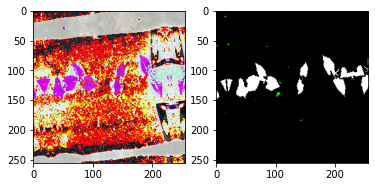

In [18]:
fig, ax = plt.subplots(1, 2)

augmented_img, target = next(iterator)
augmented_img = augmented_img[0]   # First element
augmented_img = augmented_img  # denormalize

target = np.array(target[0, ..., 0])   # First element (squeezing channel dimension)

print(np.unique(target))

target_img = np.zeros([target.shape[0], target.shape[1], 3])

target_img[np.where(target == 0)] = [0, 0, 0]
target_img[np.where(target == 1)] = [255, 255, 255]
target_img[np.where(target == 2)] = [0, 255, 0]
target_img[np.where(target == 3)] = [255, 0, 0]

ax[0].imshow(np.uint8(augmented_img))
ax[1].imshow(np.uint8(target_img))

plt.show()

In [19]:
vgg = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_h, img_w, 3))
vgg.summary()
for layer in vgg.layers:
  layer.trainable = False

58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
______________________________________________________________

In [20]:
from tensorflow.keras.applications import DenseNet201
vgg = tf.keras.applications.DenseNet201(weights='imagenet',include_top=False, input_shape=(img_h, img_w, 3))
finetuning = True

if finetuning:
    freeze_until = 15 # layer from which we want to fine-tune
    
    for layer in vgg.layers[:freeze_until]:
        layer.trainable = False
else:
    vgg.trainable = False

74842112/74836368 [==============================] - 1s 0us/step


#CNN encoder decoder

In [21]:
def create_model(depth, start_f, num_classes):

    model = tf.keras.Sequential()
    
    # Encoder
    # -------
    model.add(vgg)
    
    start_f = 256
        
    # Decoder
    # -------
    for i in range(depth):
        model.add(tf.keras.layers.UpSampling2D(2, interpolation='bilinear'))
        model.add(tf.keras.layers.Conv2D(filters=start_f,
                                         kernel_size=(3, 3),
                                         strides=(1, 1),
                                         padding='same'))
        model.add(tf.keras.layers.ReLU())

        start_f = start_f // 2

    # Prediction Layer
    # ----------------
    model.add(tf.keras.layers.Conv2D(filters=num_classes,
                                     kernel_size=(1, 1),
                                     strides=(1, 1),
                                     padding='same',
                                     activation='softmax'))
    
    return model

In [22]:
model = create_model(depth=5, 
                     start_f=8, 
                     num_classes=3)

# Visualize created model as a table
model.summary()

# Visualize initialized weights
# model.weights

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 8, 8, 1920)        18321984  
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 16, 16, 1920)      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 256)       4423936   
_________________________________________________________________
re_lu (ReLU)                 (None, 16, 16, 256)       0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       295040    
_________________________________________________________________
re_lu_1 (ReLU)               (None, 32, 32, 128)       0

#Prepare the model for training

In [23]:
# Optimization params
# -------------------

# Loss
# Sparse Categorical Crossentropy to use integers (mask) instead of one-hot encoded labels
loss = tf.keras.losses.SparseCategoricalCrossentropy() 
# learning rate
lr = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# -------------------

# Here we define the intersection over union for each class in the batch.
# Then we compute the final iou as the mean over classes
def meanIoU(y_true, y_pred):
    # get predicted class from softmax
    y_pred = tf.expand_dims(tf.argmax(y_pred, -1), -1)

    per_class_iou = []

    for i in range(1,21): # exclude the background class 0
      # Get prediction and target related to only a single class (i)
      class_pred = tf.cast(tf.where(y_pred == i, 1, 0), tf.float32)
      class_true = tf.cast(tf.where(y_true == i, 1, 0), tf.float32)
      intersection = tf.reduce_sum(class_true * class_pred)
      union = tf.reduce_sum(class_true) + tf.reduce_sum(class_pred) - intersection
    
      iou = (intersection + 1e-7) / (union + 1e-7)
      per_class_iou.append(iou)

    return tf.reduce_mean(per_class_iou)

# Validation metrics
# ------------------
metrics = ['accuracy', meanIoU]
# ------------------

# Compile Model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

#Training with callbacks

In [24]:
import os
from datetime import datetime

cwd = os.getcwd()

exps_dir = os.path.join(cwd, 'drive/My Drive/Keras4/', 'multiclass_segmentation_experiments')
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

now = datetime.now().strftime('%b%d_%H-%M-%S')

model_name = 'CNN'

exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    
callbacks = []

# Model checkpoint
# ----------------
ckpt_dir = os.path.join(exp_dir, 'ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_{epoch:02d}.ckpt'), monitor='val_accuracy',
                                                   verbose=1, save_best_only=True, mode='max',
                                                   save_weights_only=True)  # False to save the model directly
callbacks.append(ckpt_callback)

# Visualize Learning on Tensorboard
# ---------------------------------
tb_dir = os.path.join(exp_dir, 'tb_logs')
if not os.path.exists(tb_dir):
    os.makedirs(tb_dir)
    
# By default shows losses and metrics for both training and validation
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                             profile_batch=0,
                                             histogram_freq=0)  # if 1 shows weights histograms
callbacks.append(tb_callback)

# Early Stopping
# --------------
early_stop = True
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, mode='max')
    callbacks.append(es_callback)

# How to visualize Tensorboard

# 1. tensorboard --logdir EXPERIMENTS_DIR --port PORT     <- from terminal
# 2. localhost:PORT   <- in your browser

In [ ]:
!ls /content/Development_Dataset/trainingData/trainingImages/

In [25]:

model.fit(x=train_dataset,
          epochs=5,  #### set repeat in training dataset
          steps_per_epoch=len(dataset),
          validation_data=valid_dataset,
          validation_steps=len(dataset_valid), 
          callbacks=callbacks)

Epoch 1/5
144/144 [==============================] - 763s 5s/step - loss: 0.4574 - accuracy: 0.8454 - meanIoU: 0.9003 - val_loss: 0.2279 - val_accuracy: 0.9144 - val_meanIoU: 0.9000

Epoch 00001: val_accuracy improved from -inf to 0.91437, saving model to /content/drive/My Drive/Keras4/multiclass_segmentation_experiments/CNN_Dec28_20-09-49/ckpts/cp_01.ckpt
Epoch 2/5
144/144 [==============================] - 725s 5s/step - loss: 0.2359 - accuracy: 0.9028 - meanIoU: 0.9065 - val_loss: 0.2349 - val_accuracy: 0.8984 - val_meanIoU: 0.9273

Epoch 00002: val_accuracy did not improve from 0.91437
Epoch 3/5
144/144 [==============================] - 725s 5s/step - loss: 0.1842 - accuracy: 0.9190 - meanIoU: 0.9268 - val_loss: 0.1635 - val_accuracy: 0.9408 - val_meanIoU: 0.9362

Epoch 00003: val_accuracy improved from 0.91437 to 0.94081, saving model to /content/drive/My Drive/Keras4/multiclass_segmentation_experiments/CNN_Dec28_20-09-49/ckpts/cp_03.ckpt
Epoch 4/5
144/144 [======================

In [26]:
model.load_weights('/content/drive/My Drive/Keras4/multiclass_segmentation_experiments/CNN_Dec28_20-09-49/ckpts/cp_03.ckpt')

(1, 256, 256, 3)

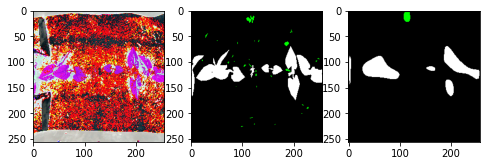

In [27]:
import time
import matplotlib.pyplot as plt

from PIL import Image

%matplotlib inline

iterator = iter(valid_dataset)

fig, ax = plt.subplots(1, 3, figsize=(8, 8))
fig.show()
image, target = next(iterator)

image = image[0]
target = target[0, ..., 0]

out_sigmoid = model.predict(x=tf.expand_dims(image, 0))

# Get predicted class as the index corresponding to the maximum value in the vector probability
# predicted_class = tf.cast(out_sigmoid > score_th, tf.int32)
# predicted_class = predicted_class[0, ..., 0]
predicted_class = tf.argmax(out_sigmoid, -1)

out_sigmoid.shape

predicted_class = predicted_class[0, ...]

# Assign colors (just for visualization)
target_img = np.zeros([target.shape[0], target.shape[1], 3])
prediction_img = np.zeros([target.shape[0], target.shape[1], 3])

target_img[np.where(target == 0)] = [0, 0, 0]
target_img[np.where(target == 1)] = [255, 255, 255]
target_img[np.where(target == 2)] = [0, 255, 0]
target_img[np.where(target == 3)] = [255, 0, 0]

# prediction_img[np.where(predicted_class == 0)] = [0, 0, 0]

prediction_img[np.where(predicted_class == 0)] = [0, 0, 0]
prediction_img[np.where(predicted_class == 1)] = [255, 255, 255]
prediction_img[np.where(predicted_class == 2)] = [0, 255, 0]
prediction_img[np.where(predicted_class == 3)] = [255, 0, 0]

ax[0].imshow(np.uint8(image))
ax[1].imshow(np.uint8(target_img))
ax[2].imshow(np.uint8(prediction_img))

fig.canvas.draw()
time.sleep(1)


In [28]:
#getting test images
from keras.preprocessing.image import save_img
def submit(submission_dict,team,crop):
    path_mask='Development_Dataset/Test_Dev/Bipbip/Haricot/Masks'
    if not os.path.exists(path_mask):
      os.mkdir(path_mask)
    path ="Development_Dataset/Test_Dev/"
    dir= os.path.join(path,team,crop,'Images')
    predicted_images =next(os.walk(dir))[2]
    print (type(predicted_images))
    for img in predicted_images:
      mask_img = img.split(".")
      mask_img=mask_img[0]
      test_image = Image.open(os.path.join(dir,img))
      #print (test_image)
      size=(256,256)
      test_image = test_image.resize(size)
      tf_test_image = tf.convert_to_tensor(
      np.array(test_image), dtype='float32'
      )
      out_sigmoid = model.predict(x=tf.expand_dims(tf_test_image, 0))
      predicted_class = tf.argmax(out_sigmoid, -1)
      predicted_class = predicted_class[0, ...]

      prediction_img = np.zeros([tf_test_image.shape[0], tf_test_image.shape[1], 3])
      prediction_img[np.where(predicted_class == 0)] = [0, 0, 0]
      prediction_img[np.where(predicted_class == 1)] = [255, 255, 255]
      prediction_img[np.where(predicted_class == 2)] = [216, 67, 82]
      #print(predicted_class)
      #path_mask=/content/Bipbip_haricot_im_00211.png
      save_img('Development_Dataset/Test_Dev/Bipbip/Haricot/Masks/' + mask_img + '.png',prediction_img)

      mask_arr=read_rgb_mask("Development_Dataset/Test_Dev/Bipbip/Haricot/Masks/" + mask_img + '.png')
      #print(mask_arr)
      submission_dict[mask_img] = {}
      submission_dict[mask_img]['shape'] = mask_arr.shape
      submission_dict[mask_img]['team'] = team
      submission_dict[mask_img]['crop'] = crop
      submission_dict[mask_img]['segmentation'] = {}

      # RLE encoding
      # crop
      rle_encoded_crop = rle_encode(mask_arr == 1)
      # weed
      rle_encoded_weed = rle_encode(mask_arr == 2)

      submission_dict[mask_img]['segmentation']['crop'] = rle_encoded_crop
      submission_dict[mask_img]['segmentation']['weed'] = rle_encoded_weed
      print(submission_dict)
    return submission_dict


In [29]:
#reading rgb masks

import os
import numpy as np
from PIL import Image


def read_rgb_mask(img_path):
    '''
    img_path: path to the mask file
    Returns the numpy array containing target values
    '''

    mask_img = Image.open(img_path)
    mask_arr = np.array(mask_img)

    new_mask_arr = np.zeros(mask_arr.shape[:2], dtype=mask_arr.dtype)

    # Use RGB dictionary in 'RGBtoTarget.txt' to convert RGB to target
    new_mask_arr[np.where(np.all(mask_arr == [255, 255, 255], axis=-1))] = 1
    new_mask_arr[np.where(np.all(mask_arr == [216, 67, 82], axis=-1))] = 2

    return new_mask_arr


In [30]:
import os
import json
import numpy as np
from PIL import Image


def rle_encode(img):
    '''
    img: numpy array, 1 - foreground, 0 - background
    Returns run length as string formatted
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [31]:
#def submission():
submission_dict = {}

submission_dict = submit(submission_dict,'Bipbip','Haricot')

<class 'list'>
{'Bipbip_haricot_im_02841': {'shape': (256, 256), 'team': 'Bipbip', 'crop': 'Haricot', 'segmentation': {'crop': '25221 5 25475 9 25729 11 25983 14 26237 16 26492 17 26746 19 27001 20 27255 22 27510 23 27765 24 28019 26 28274 26 28458 3 28529 27 28712 7 28783 29 28967 9 29038 30 29222 11 29293 30 29478 12 29548 31 29733 13 29803 32 29988 15 30058 32 30244 15 30313 33 30499 17 30568 33 30755 17 30823 34 31010 19 31078 34 31266 19 31333 35 31521 20 31589 34 31777 21 31844 35 32032 22 32100 34 32288 22 32356 33 32543 24 32612 33 32799 24 32868 32 33055 24 33124 31 33310 26 33380 30 33566 26 33637 28 33822 26 33894 26 34077 27 34151 24 34333 27 34408 21 34589 28 34845 28 35101 28 35357 28 35613 28 35869 28 36125 28 36381 28 36638 27 36894 27 37150 27 37407 25 37664 24 37921 22 38177 22 38435 19 38692 17 38950 13 39209 7 42115 2 42370 4 42626 5 42882 5 43139 5 43395 5 43653 2', 'weed': '30208 1 30464 1 30719 2 30975 2 31230 3 31486 3 31742 3 31998 3 32253 4 32509 4 32765 4 330

In [33]:
# Finally, save the results into the submission.json file
with open('submission.json', 'w') as f:
  json.dump(submission_dict, f)

In [ ]:
from google.colab import files
files.download('submission.json') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>